# Segmentación Semántica con SegNet

**Autora:** Julia García Vega

**Fecha:** 02/07/2024

**Descripción:** Implementación de la arquitectura SegNet para la segmentación semántica de múltiples clases.


## Configuración inicial

In [1]:
# para cargar los datos
import os
!pip install roboflow
from roboflow import Roboflow

# para leer y procesar imágenes
import imageio
from PIL import Image

# para trabajar con arrays
import numpy as np

# para visualizaciones de imágenes y gráficos
import matplotlib.pyplot as plt

# para la generación de números aleatorios
import random

# para construir y ejecutar modelos de aprendizaje profundo
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model

# para descargar el fichero del modelo resultante
from google.colab import files

# para métricas de evaluación de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score, accuracy_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.3 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler

In [2]:
CLASSES_NAMES = ['fondo', 'acera', 'baldosas podotáctiles', 'banco', 'carretera', 'pared', 'paso de cebra', 'vegetación']
BACKGROUND = [255,255,255]
SIDEWALK = [155, 155, 155]
PODOTACTILE_PAVEMENT = [255, 89, 94]
BENCH = [255, 146, 76]
ROAD = [28, 48, 74]
WALL = [255, 202, 58]
CROSSWALK = [25, 130, 196]
VEGETATION = [138, 201, 38]
COLOR_DICT = np.array([BACKGROUND, SIDEWALK, PODOTACTILE_PAVEMENT, BENCH, ROAD, WALL, CROSSWALK, VEGETATION])
TARGET_SHAPE_IMG = [128, 128, 3]
TARGET_SHAPE_MASK = [128, 128, 1]
BATCH_SIZE = 32
NUM_CLASSES = 8
TRAIN_DIR = '/content/Elementos-acera-2-12/train/'
VALID_DIR = '/content/Elementos-acera-2-12/valid/'
TEST_DIR = '/content/Elementos-acera-2-12/test/'

In [3]:
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = COLOR_DICT
    if np.max(label) > len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

## Importación de los datos

Se procede a descargar el conjunto de datos del proyecto personal de Roboflow en el que se ha llevado acabo la anotación de las imágenes. Está compuesto por 5217 y se distinguen las siguientes clases:

*   Fondo
*   Acera
*   Baldosas podotáctiles
*   Banco
*   Carretera
*   Pared
*   Paso de cebra
*   Vegetación

In [4]:
# IMPORTANTE: La siguiente línea contiene la API key de Roboflow, la cual ha sido reemplazada por asteriscos por motivos de seguridad.
# En caso de necesitar acceso a la API key original para la reproducción o evaluación del trabajo, por favor, solicitarla a juliagarve@usal.es.

rf = Roboflow(api_key="********************")
project = rf.workspace("tfg-nrlv7").project("elementos-acera-2")
dataset = project.version(12).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Elementos-acera-2-12 in png-mask-semantic:: 100%|██████████| 11926/11926 [00:02<00:00, 5637.39it/s]


In [5]:
def LoadData (path):
    """
    Carga los datos devolviendo dos listas, una con los nombres de los ficheros
    de imágenes y otra con los nombres de los ficheros de las máscaras
    """
    #Obtener un listado de los archivos en esa ubicación
    dataset = os.listdir(path)

    #Filtrar respectivamente las imágenes (archivos .jpg) y las máscaras (archivos .png)
    image_dataset = [file_name for file_name in dataset if file_name.endswith('.jpg')]
    mask_dataset = [file_name for file_name in dataset if file_name.endswith('.png')]

    # Ordenar ambas listas para que tengan en el mismo índice la imagen y máscara correspondiente
    image_dataset.sort()
    mask_dataset.sort()

    return image_dataset, mask_dataset

train_image_dataset, train_mask_dataset = LoadData(TRAIN_DIR)
valid_image_dataset, valid_mask_dataset = LoadData(VALID_DIR)
test_image_dataset, test_mask_dataset = LoadData(TEST_DIR)

In [6]:
NUM_TRAIN_IMAGES = len(train_mask_dataset)
NUM_VALID_IMAGES = len(valid_mask_dataset)
NUM_TEST_IMAGES = len(test_mask_dataset)

print("Número imágenes entrenamiento: ", NUM_TRAIN_IMAGES)
print("Número imágenes validación: ", NUM_VALID_IMAGES)
print("Número imágenes test: ", NUM_TEST_IMAGES)

Número imágenes entrenamiento:  5217
Número imágenes validación:  495
Número imágenes test:  247


Inicialmente, debido a que se consideraron dos clases adicionales (escaleras de subida y escaleras de bajada), al eliminarlas y extraer el conjunto de datos de Roboflow los valores enteros correspondientes con cada clase quedaron descuadrados siendo asignadas por Roboflow de la siguiente manera [0, 1, 2, 3, 4, 7, 8, 9] como se puede observar a continuación. Por ello, se procede a corregir este hueco en la secuencia sustituyendo la clase 7 por la clase 5, la clase 8 por la clase 6 y la clase 9 por la clase 7.

In [7]:
def testUniqueValues(path, mask_dataset):
    """
    Comprueba los valores únicos existentes en las máscaras
    """
    # Lista para almacenar todos los valores únicos de píxeles
    unique_total_values = set()
    i=0
    # Recorrer todos los píxeles de la imagen
    for mask_name in mask_dataset:
        # Cargar la imagen
        image_path = os.path.join(path, mask_name)
        image = imageio.imread(image_path)
        # Obtener los valores únicos de la imagen actual
        unique_image_values = np.unique(image)
        # Agregar los valores únicos de la imagen actual al conjunto total
        unique_total_values.update(unique_image_values)

    # Convertir el conjunto de valores únicos en una lista para imprimir
    unique_total_values = list(unique_total_values)

    # Imprimir los valores únicos de todos los píxeles en todas las imágenes
    print("Valores únicos de píxeles en todo el conjunto de imágenes:")
    print(unique_total_values)

In [8]:
def adjustUniqueValues(path, mask_dataset):
    """
    Ajusta los valores únicos existentes en las máscaras para corregir la falta de clases
    """
    # Lista para almacenar todos los valores únicos de píxeles
    unique_total_values = set()
    i=0
    # Recorrer todos los píxeles de la imagen
    for mask_name in mask_dataset:
        # Cargar la imagen
        image_path = os.path.join(path, mask_name)
        image = imageio.imread(image_path)
        # Reemplazar los valores 7, 8 y 9 por 5, 6 y 7 respectivamente
        image = np.where(image == 7, 5, image)
        image = np.where(image == 8, 6, image)
        image = np.where(image == 9, 7, image)
        # Obtener los valores únicos de la imagen actual
        unique_image_values = np.unique(image)
        # Agregar los valores únicos de la imagen actual al conjunto total
        unique_total_values.update(unique_image_values)

        # Guardar la imagen modificada en la misma ubicación con el mismo nombre
        imageio.imwrite(image_path, image)

    # Convertir el conjunto de valores únicos en una lista para imprimir
    unique_total_values = list(unique_total_values)

    # Imprimir los valores únicos de todos los píxeles en todas las imágenes
    print("Valores únicos de píxeles en todo el conjunto de imágenes:")
    print(unique_total_values)

In [9]:
testUniqueValues(TRAIN_DIR, train_mask_dataset)
testUniqueValues(VALID_DIR, valid_mask_dataset)
testUniqueValues(TEST_DIR, test_mask_dataset)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]


In [10]:
adjustUniqueValues(TRAIN_DIR, train_mask_dataset)
adjustUniqueValues(VALID_DIR, valid_mask_dataset)
adjustUniqueValues(TEST_DIR, test_mask_dataset)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]


## Visualización de imágenes y su máscara correspondiente

Dimensión imágen:  (640, 640, 3)
Dimensión máscara:  (640, 640)
Dimensión imágen:  (640, 640, 3)
Dimensión máscara:  (640, 640)


Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


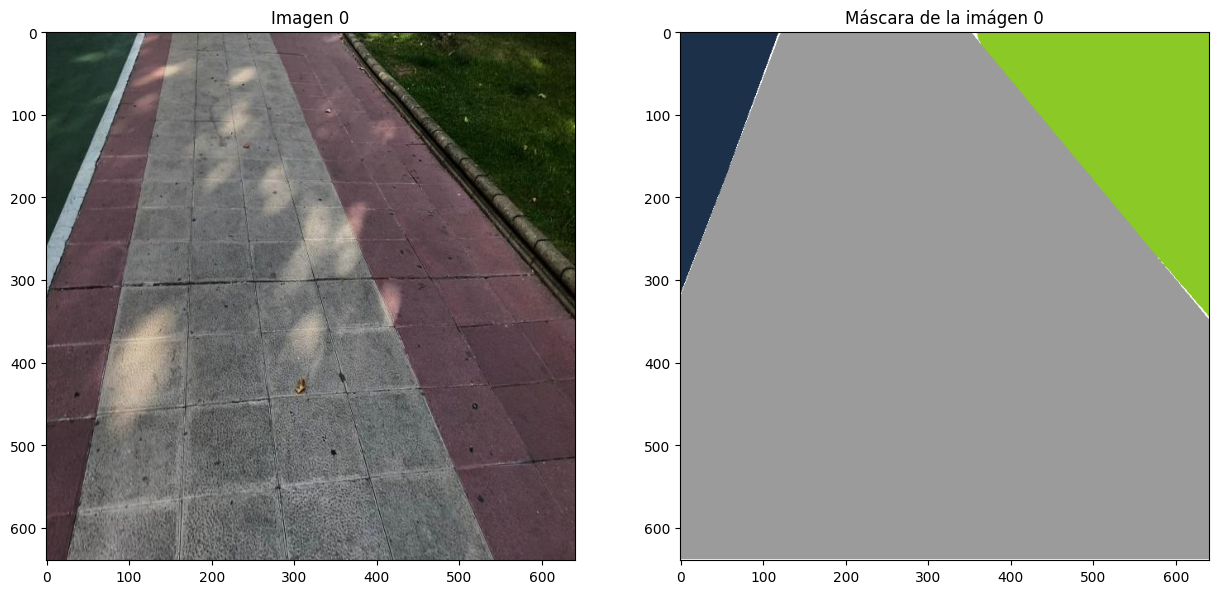

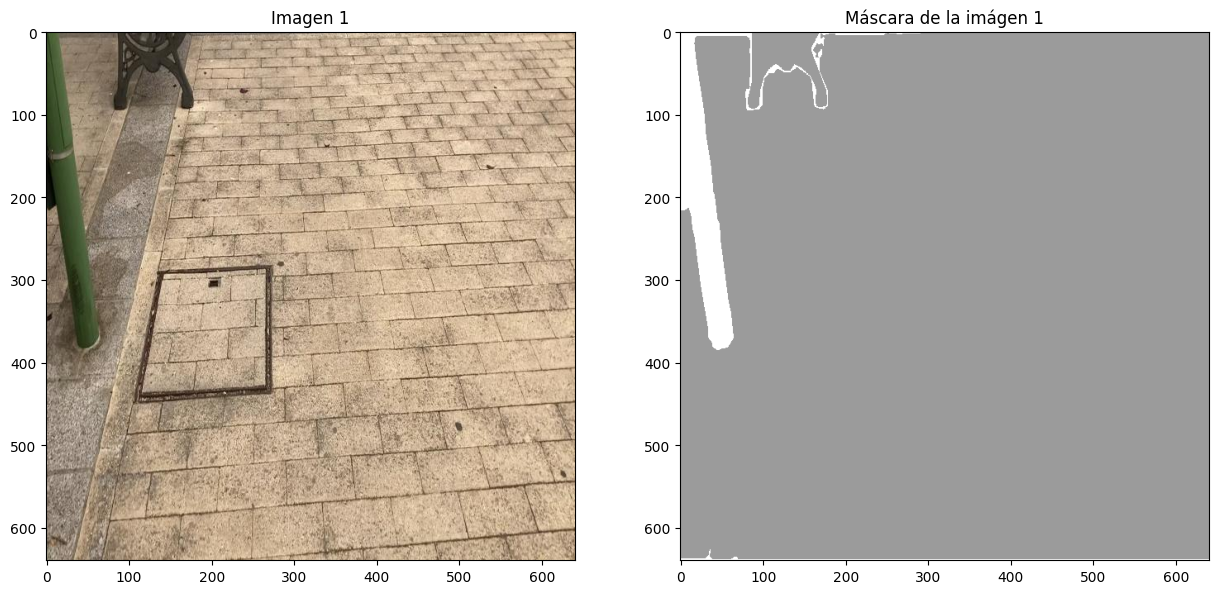

In [11]:
show_images = 2
random_ints = np.random.randint(0, NUM_TRAIN_IMAGES - 1, size=show_images)
for index, num in enumerate(random_ints):
    img_view  = imageio.imread(TRAIN_DIR + train_image_dataset[num])
    mask_view = imageio.imread(TRAIN_DIR + train_mask_dataset[num])
    mask_view_color = label_to_color_image(mask_view).astype(np.uint8)
    print("Dimensión imágen: ", img_view.shape)
    print("Dimensión máscara: ", mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Imagen '+ str(index))
    arr[1].imshow(mask_view_color)
    arr[1].set_title('Máscara de la imágen '+ str(index))

## Preprocesamiento del conjunto de datos


In [12]:
def PreprocessData(image_dataset, mask_dataset, target_shape_img, target_shape_mask, path):
    """
    Preprocesa las imágenes y mascaras presentes en las listas y la ubicación
    pasada como argumento.
    Devuelve dos arrays de cuatro dimensiones que contienen las imágenes y máscaras
    como arrays. Las dimensiones corresponden con lo siguiente:
        Primera dimensión:              número de imágenes/máscaras
        Segunda y tercera dimensión:    ancho y alto deseado
        Cuarta dimensión:               número de canales.
                                            las imágenes 3 canales (RGB)
                                            las máscaras 1 canal (escala de grises)
    """
    # Extraer las dimensiones relevantes
    num_images = len(image_dataset)  # número de imágenes
    i_h,i_w,i_c = target_shape_img   # altura, ancho y canales de una imagen
    m_h,m_w,m_c = target_shape_mask  # altura, ancho y canales de una máscara

    # Definir X e Y como el número de imágenes junto con la dimensión de una imagen
    X = np.zeros((num_images,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((num_images,m_h,m_w,m_c), dtype=np.int32)

    # Redimensionar imágenes y máscaras
    for i in range(num_images):
        # convertir la imagen en un array con la forma deseada
        image_name = image_dataset[i]
        image_path = os.path.join(path, image_name)
        image = Image.open(image_path).convert('RGB')
        image = image.resize((i_h,i_w))
        image = np.reshape(image,(i_h,i_w,i_c))
        image = image/255.
        X[i] = image

        # convertir la máscara en un array con la forma deseada
        mask_name = mask_dataset[i]
        mask_path = os.path.join(path, mask_name)
        mask = Image.open(mask_path)
        mask = mask.resize((m_h, m_w),Image.NEAREST) #Con flag Image.NEAREST para que no se cree una nueva clase por la interpolación de los píxeles
        mask = np.reshape(mask,(m_h,m_w,m_c))

        y[i] = mask

    return X, y

In [13]:
X_train, y_train = PreprocessData(train_image_dataset, train_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, TRAIN_DIR)
X_valid, y_valid = PreprocessData(valid_image_dataset, valid_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, VALID_DIR)
X_test, y_test = PreprocessData(test_image_dataset, test_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, TEST_DIR)

print("Dimensión conjunto de imágenes de entrenamiento: ", X_train.shape)
print("Dimensión conjunto de máscaras de entrenamiento: ", y_train.shape)
print("Dimensión conjunto de imágenes de validación: ", X_valid.shape)
print("Dimensión conjunto de máscaras de validación: ", y_valid.shape)
print("Dimensión conjunto de imágenes de prueba: ", X_test.shape)
print("Dimensión conjunto de máscaras de prueba: ", y_test.shape)

Dimensión conjunto de imágenes de entrenamiento:  (5217, 128, 128, 3)
Dimensión conjunto de máscaras de entrenamiento:  (5217, 128, 128, 1)
Dimensión conjunto de imágenes de validación:  (495, 128, 128, 3)
Dimensión conjunto de máscaras de validación:  (495, 128, 128, 1)
Dimensión conjunto de imágenes de prueba:  (247, 128, 128, 3)
Dimensión conjunto de máscaras de prueba:  (247, 128, 128, 1)


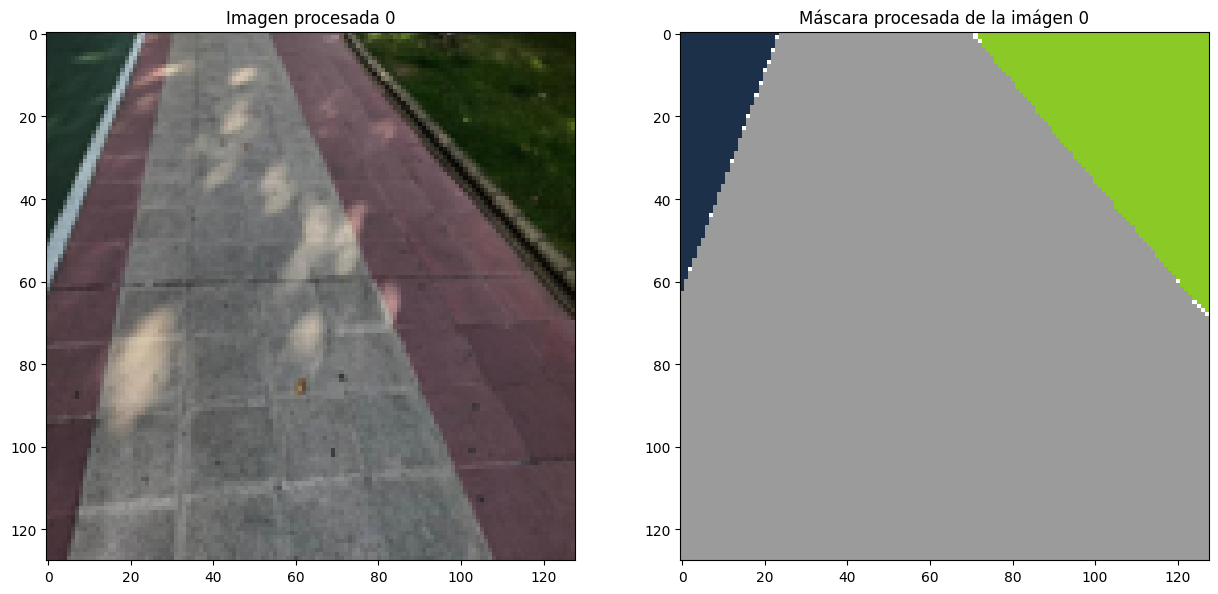

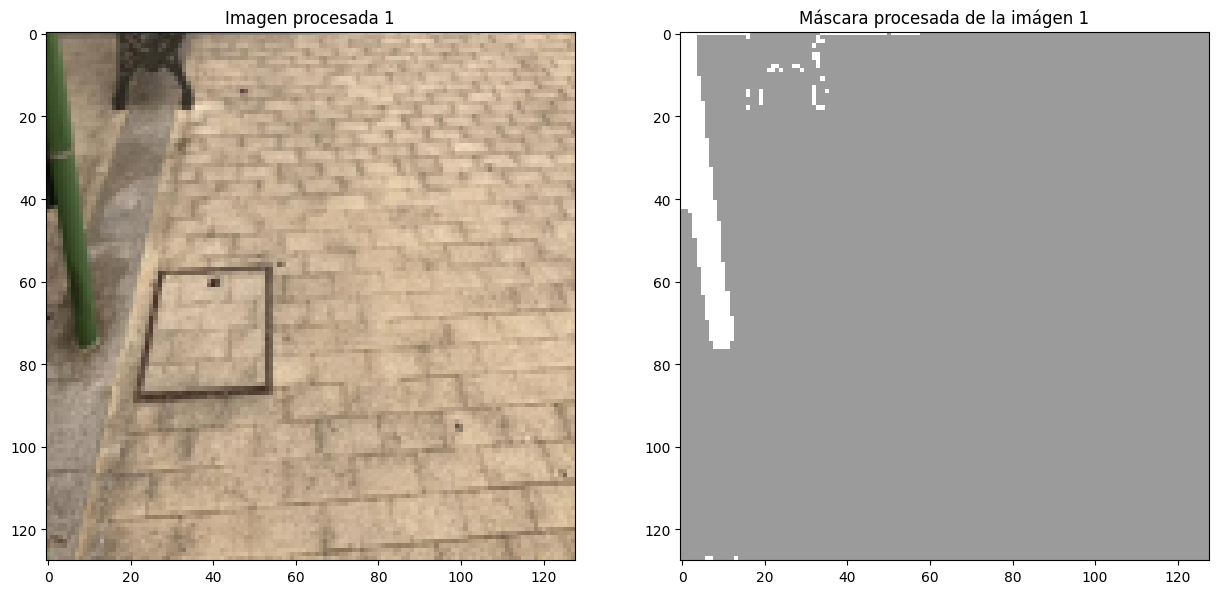

In [14]:
for index, num in enumerate(random_ints):
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(X_train[num])
    arr[0].set_title('Imagen procesada '+ str(index))
    mask_view_color = label_to_color_image(y_train[num,:,:,0]).astype(np.uint8)
    arr[1].imshow(mask_view_color)
    arr[1].set_title('Máscara procesada de la imágen '+ str(index))

## Construcción de la arquitectura SegNet

In [15]:
# Modelo obtenido modificando: Hashbanger. (2019b, julio 15). Skin Lesion Segmentation using SegNet. Kaggle. https://www.kaggle.com/code/hashbanger/skin-lesion-segmentation-using-segnet#The-Model

def segnet(input_size=(128, 128, 3), n_labels=8, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(input_size)

    conv_1 = Conv2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Conv2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1 = MaxPooling2D(pool_size)(conv_2)

    conv_3 = Conv2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2 = MaxPooling2D(pool_size)(conv_4)

    conv_5 = Conv2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)


    pool_3 = MaxPooling2D(pool_size)(conv_7)

    conv_8 = Conv2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Conv2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Conv2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)


    pool_4 = MaxPooling2D(pool_size)(conv_10)

    conv_11 = Conv2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)


    pool_5 = MaxPooling2D(pool_size)(conv_13)

    # decoder

    up_1 = UpSampling2D(pool_size)(pool_5)

    conv_14 = Conv2D(512, (kernel, kernel), padding="same")(up_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)


    up_2 = UpSampling2D(pool_size)(conv_16)

    conv_17 = Conv2D(512, (kernel, kernel), padding="same")(up_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Conv2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    up_3 = UpSampling2D(pool_size)(conv_19)

    conv_20 = Conv2D(256, (kernel, kernel), padding="same")(up_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Conv2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Conv2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    up_4 = UpSampling2D(pool_size)(conv_22)

    conv_23 = Conv2D(128, (kernel, kernel), padding="same")(up_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Conv2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    up_5 = UpSampling2D(pool_size)(conv_24)

    conv_25 = Conv2D(64, (kernel, kernel), padding="same")(up_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Conv2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    outputs = Activation(output_mode)(conv_26)

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

Se definen 4 modelos iguales para utilizar con cada una de las siguientes configuraciones:
*   Función de pérdida de entropía cruzada y optimización Adam
*   Función de pérdida de entropía cruzada y optimización SGD
*   Función de pérdida focal y optimización Adam
*   Función de pérdida focal cruzada y optimización SGD

In [16]:
model_ce_adam = segnet(TARGET_SHAPE_IMG, n_labels=NUM_CLASSES ,kernel=3, pool_size=(2,2), output_mode="softmax")
model_ce_sgd = segnet(TARGET_SHAPE_IMG, n_labels=NUM_CLASSES ,kernel=3, pool_size=(2,2), output_mode="softmax")
model_focal_adam = segnet(TARGET_SHAPE_IMG, n_labels=NUM_CLASSES ,kernel=3, pool_size=(2,2), output_mode="softmax")
model_focal_sgd = segnet(TARGET_SHAPE_IMG, n_labels=NUM_CLASSES ,kernel=3, pool_size=(2,2), output_mode="softmax")

A continuación se muestra la arquitectura detallada de los modelos

In [17]:
model_ce_adam.summary()

Model: "SegNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                           

## Definición de las métricas para utilizar en el entrenamiento

In [31]:
def iou(y_true, y_pred):
  y_pred = K.argmax(y_pred, axis=-1)
  y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

  y_true = K.squeeze(y_true, axis=-1)
  y_true_int = K.cast(y_true, 'int32')
  y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

  intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
  union = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3]) - intersection
  iou = (intersection + K.epsilon()) / (union + K.epsilon())
  return iou

def iou_one_hot(y_true, y_pred):
  y_pred = K.argmax(y_pred, axis=-1)
  y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

  y_true_one_hot = y_true

  intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
  union = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3]) - intersection
  iou = (intersection + K.epsilon()) / (union + K.epsilon())
  return iou

In [19]:
def dice_coef(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
    total_pixels = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3])
    dice_coef = (2 * intersection + K.epsilon()) / (total_pixels + K.epsilon())
    return dice_coef

def dice_coef_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
    total_pixels = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3])
    dice_coef = (2 * intersection + K.epsilon()) / (total_pixels + K.epsilon())
    return dice_coef

In [20]:
def precision(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    pred_positives = K.sum(y_pred_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (pred_positives + K.epsilon())
    return precision

def precision_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    pred_positives = K.sum(y_pred_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (pred_positives + K.epsilon())
    return precision

In [21]:
def recall(y_true, y_pred):

    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    truth_positives = K.sum(y_true_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (truth_positives + K.epsilon())
    return precision

def recall_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    truth_positives = K.sum(y_true_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (truth_positives + K.epsilon())
    return precision

In [22]:
def accuracy(y_true, y_pred):
    y_pred_int = K.cast(K.argmax(y_pred, axis=-1), 'int32')
    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')

    correct_predictions = K.sum(K.cast(K.equal(y_true_int, y_pred_int), dtype='float32'), axis=[1,2])
    total_pixels = K.constant(16384.0, dtype='float32')
    accuracy = (correct_predictions + K.epsilon()) / (total_pixels + K.epsilon())
    return accuracy

def accuracy_one_hot(y_true, y_pred):
    y_pred_int = K.cast(K.argmax(y_pred, axis=-1), 'int32')

    y_true_int = K.cast(K.argmax(y_true, axis=-1), 'int32')

    correct_predictions = K.sum(K.cast(K.equal(y_true_int, y_pred_int), dtype='float32'), axis=[1,2])
    total_pixels = K.constant(16384.0, dtype='float32')
    accuracy = (correct_predictions + K.epsilon()) / (total_pixels + K.epsilon())
    return accuracy

## Entrenamiento

### Pérdida focal y Adam

In [23]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

In [24]:
model_focal_adam.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.CategoricalFocalCrossentropy(from_logits=False),
              metrics=[accuracy_one_hot, iou_one_hot, dice_coef_one_hot, precision_one_hot, recall_one_hot])

results_focal_adam = model_focal_adam.fit(X_train, y_train_one_hot, batch_size=32, epochs=30, validation_data=(X_valid, y_valid_one_hot))

Epoch 1/30
164/164 [==============================] - 89s 368ms/step - loss: 0.2468 - accuracy_one_hot: 0.6358 - iou_one_hot: 0.5131 - dice_coef_one_hot: 0.6358 - precision_one_hot: 0.6358 - recall_one_hot: 0.6358 - val_loss: 0.2748 - val_accuracy_one_hot: 0.5781 - val_iou_one_hot: 0.4766 - val_dice_coef_one_hot: 0.5781 - val_precision_one_hot: 0.5781 - val_recall_one_hot: 0.5781
Epoch 2/30
164/164 [==============================] - 55s 333ms/step - loss: 0.1743 - accuracy_one_hot: 0.7067 - iou_one_hot: 0.5889 - dice_coef_one_hot: 0.7067 - precision_one_hot: 0.7067 - recall_one_hot: 0.7067 - val_loss: 0.2584 - val_accuracy_one_hot: 0.6059 - val_iou_one_hot: 0.5046 - val_dice_coef_one_hot: 0.6059 - val_precision_one_hot: 0.6059 - val_recall_one_hot: 0.6059
Epoch 3/30
164/164 [==============================] - 55s 337ms/step - loss: 0.1392 - accuracy_one_hot: 0.7580 - iou_one_hot: 0.6468 - dice_coef_one_hot: 0.7580 - precision_one_hot: 0.7580 - recall_one_hot: 0.7580 - val_loss: 0.2177 -

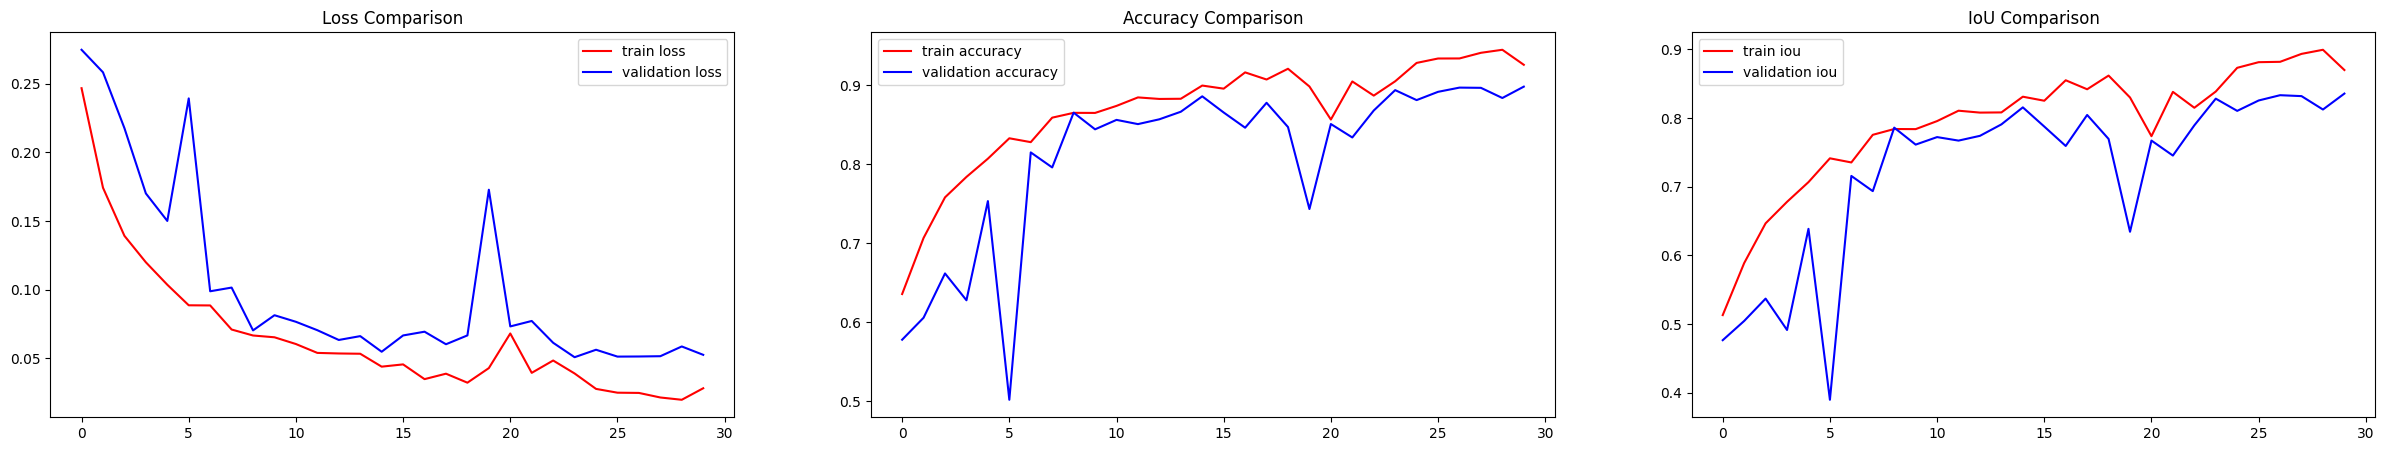

In [25]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_focal_adam.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_focal_adam.history["val_loss"], color='b', label = 'validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results_focal_adam.history["accuracy_one_hot"], color='r', label = 'train accuracy')
axis[1].plot(results_focal_adam.history["val_accuracy_one_hot"], color='b', label = 'validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[2].plot(results_focal_adam.history["iou_one_hot"], color='r', label = 'train iou')
axis[2].plot(results_focal_adam.history["val_iou_one_hot"], color='b', label = 'validation iou')
axis[2].set_title('IoU Comparison')
axis[2].legend()

### Pérdida focal y SGD

In [26]:
model_focal_sgd.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.CategoricalFocalCrossentropy(from_logits=False),
              metrics=[accuracy_one_hot, iou_one_hot, dice_coef_one_hot])

results_focal_sgd = model_focal_sgd.fit(X_train, y_train_one_hot, batch_size=32, epochs=30, validation_data=(X_valid, y_valid_one_hot))

Epoch 1/30
164/164 [==============================] - 64s 348ms/step - loss: 0.3812 - accuracy_one_hot: 0.3045 - iou_one_hot: 0.1919 - dice_coef_one_hot: 0.3045 - val_loss: 0.3588 - val_accuracy_one_hot: 0.3927 - val_iou_one_hot: 0.2501 - val_dice_coef_one_hot: 0.3927
Epoch 2/30
164/164 [==============================] - 56s 343ms/step - loss: 0.2938 - accuracy_one_hot: 0.5378 - iou_one_hot: 0.3949 - dice_coef_one_hot: 0.5378 - val_loss: 0.3037 - val_accuracy_one_hot: 0.5390 - val_iou_one_hot: 0.4148 - val_dice_coef_one_hot: 0.5390
Epoch 3/30
164/164 [==============================] - 56s 342ms/step - loss: 0.2260 - accuracy_one_hot: 0.6549 - iou_one_hot: 0.5215 - dice_coef_one_hot: 0.6549 - val_loss: 0.2598 - val_accuracy_one_hot: 0.5871 - val_iou_one_hot: 0.4799 - val_dice_coef_one_hot: 0.5871
Epoch 4/30
164/164 [==============================] - 56s 343ms/step - loss: 0.1812 - accuracy_one_hot: 0.7115 - iou_one_hot: 0.5832 - dice_coef_one_hot: 0.7115 - val_loss: 0.3265 - val_accurac

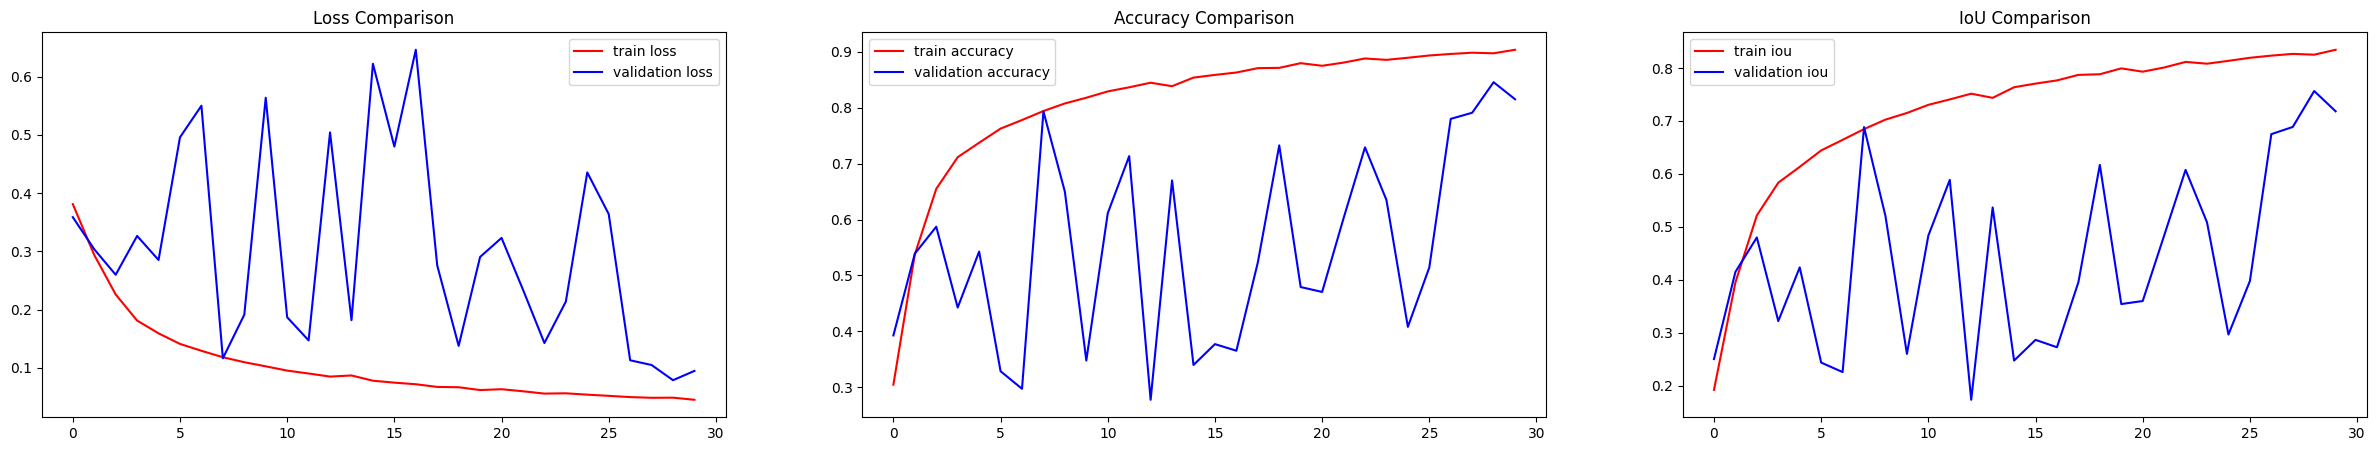

In [27]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_focal_sgd.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_focal_sgd.history["val_loss"], color='b', label = 'validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results_focal_sgd.history["accuracy_one_hot"], color='r', label = 'train accuracy')
axis[1].plot(results_focal_sgd.history["val_accuracy_one_hot"], color='b', label = 'validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[2].plot(results_focal_sgd.history["iou_one_hot"], color='r', label = 'train iou')
axis[2].plot(results_focal_sgd.history["val_iou_one_hot"], color='b', label = 'validation iou')
axis[2].set_title('IoU Comparison')
axis[2].legend()

### Entropía cruzada categórica dispersa y Adam

In [32]:
model_ce_adam.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[accuracy, iou, dice_coef])

results_ce_adam = model_ce_adam.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
164/164 [==============================] - 66s 327ms/step - loss: 1.5298 - accuracy: 0.6223 - iou: 0.4956 - dice_coef: 0.6223 - val_loss: 1.6209 - val_accuracy: 0.5597 - val_iou: 0.4443 - val_dice_coef: 0.5597
Epoch 2/30
164/164 [==============================] - 54s 327ms/step - loss: 1.2261 - accuracy: 0.6948 - iou: 0.5771 - dice_coef: 0.6948 - val_loss: 1.2712 - val_accuracy: 0.6311 - val_iou: 0.5060 - val_dice_coef: 0.6311
Epoch 3/30
164/164 [==============================] - 54s 332ms/step - loss: 1.0398 - accuracy: 0.7426 - iou: 0.6279 - dice_coef: 0.7426 - val_loss: 1.2688 - val_accuracy: 0.6535 - val_iou: 0.5540 - val_dice_coef: 0.6535
Epoch 4/30
164/164 [==============================] - 55s 333ms/step - loss: 0.8555 - accuracy: 0.7925 - iou: 0.6889 - dice_coef: 0.7925 - val_loss: 1.3711 - val_accuracy: 0.6326 - val_iou: 0.5339 - val_dice_coef: 0.6326
Epoch 5/30
164/164 [==============================] - 55s 335ms/step - loss: 0.7644 - accuracy: 0.8099 - iou: 0.7131

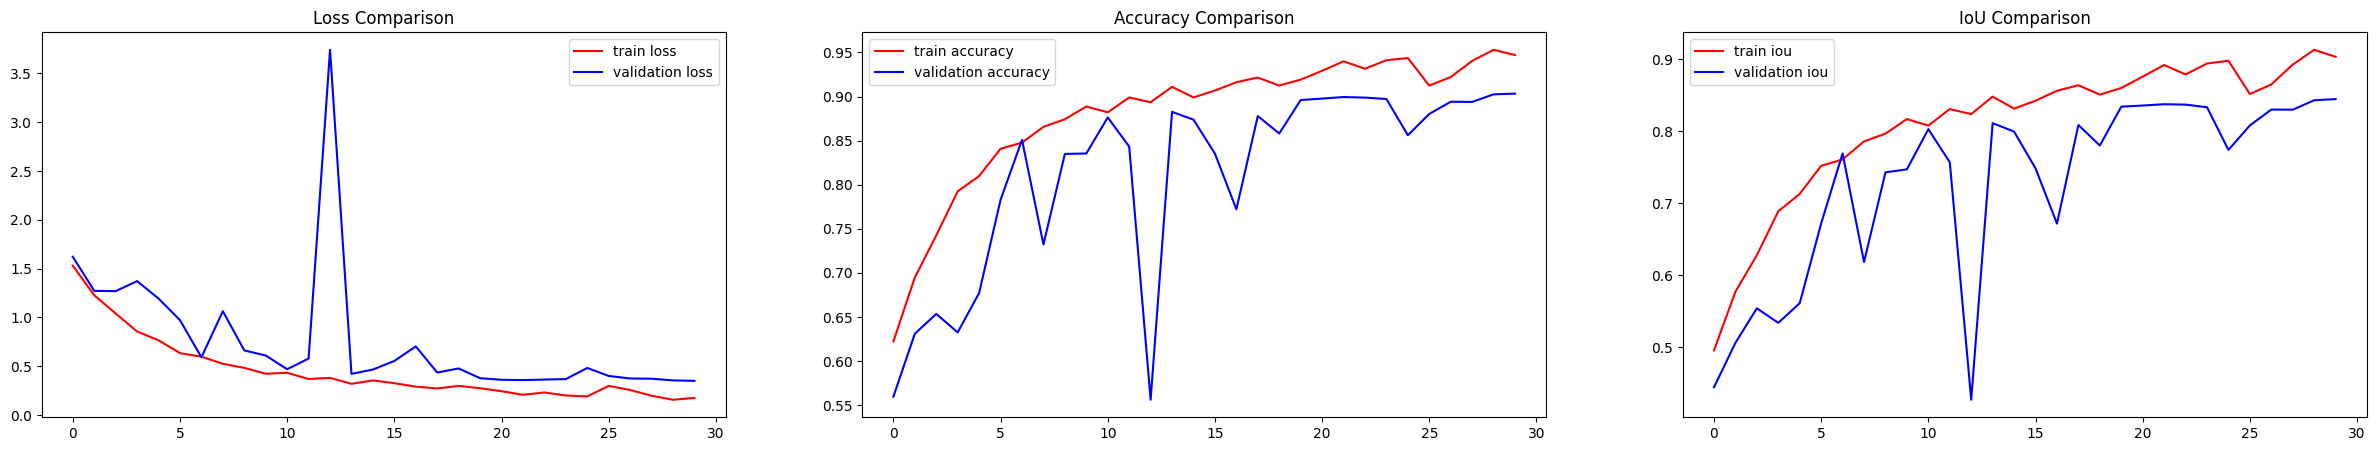

In [33]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_ce_adam.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_ce_adam.history["val_loss"], color='b', label = 'validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results_ce_adam.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results_ce_adam.history["val_accuracy"], color='b', label = 'validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[2].plot(results_ce_adam.history["iou"], color='r', label = 'train iou')
axis[2].plot(results_ce_adam.history["val_iou"], color='b', label = 'validation iou')
axis[2].set_title('IoU Comparison')
axis[2].legend()

### Entropía cruzada categórica dispersa y SGD

In [34]:
model_ce_sgd.compile(optimizer=tf.keras.optimizers.SGD(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[accuracy, iou, dice_coef])

results_ce_sgd = model_ce_sgd.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
164/164 [==============================] - 62s 338ms/step - loss: 1.5729 - accuracy: 0.5500 - iou: 0.4156 - dice_coef: 0.5500 - val_loss: 1.5103 - val_accuracy: 0.5777 - val_iou: 0.4749 - val_dice_coef: 0.5777
Epoch 2/30
164/164 [==============================] - 55s 334ms/step - loss: 1.0679 - accuracy: 0.7265 - iou: 0.6037 - dice_coef: 0.7265 - val_loss: 1.5123 - val_accuracy: 0.5324 - val_iou: 0.4158 - val_dice_coef: 0.5324
Epoch 3/30
164/164 [==============================] - 55s 335ms/step - loss: 0.8515 - accuracy: 0.7831 - iou: 0.6732 - dice_coef: 0.7831 - val_loss: 1.3467 - val_accuracy: 0.5922 - val_iou: 0.4812 - val_dice_coef: 0.5922
Epoch 4/30
164/164 [==============================] - 55s 336ms/step - loss: 0.7016 - accuracy: 0.8222 - iou: 0.7237 - dice_coef: 0.8222 - val_loss: 3.7203 - val_accuracy: 0.1949 - val_iou: 0.1439 - val_dice_coef: 0.1949
Epoch 5/30
164/164 [==============================] - 55s 336ms/step - loss: 0.6066 - accuracy: 0.8446 - iou: 0.7532

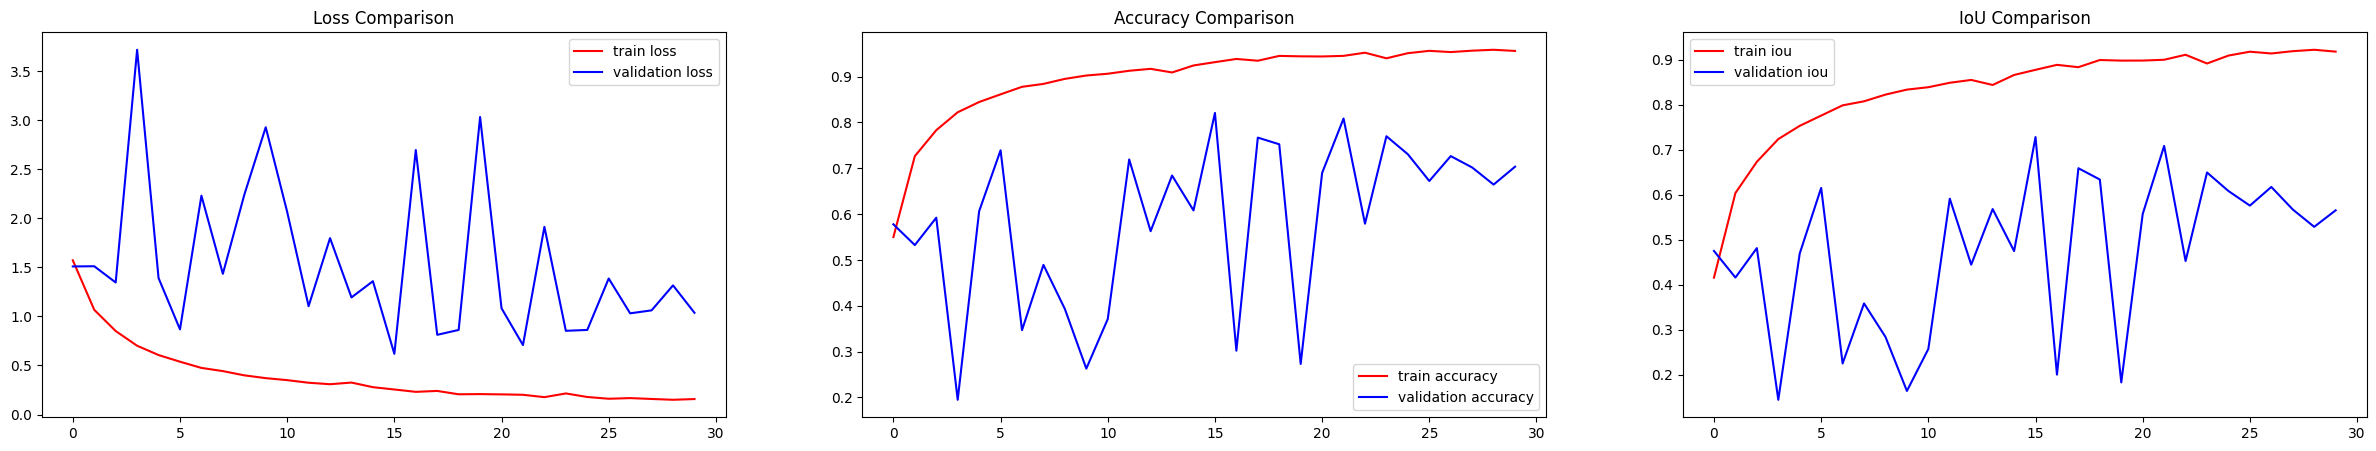

In [35]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_ce_sgd.history["loss"], color='r', label = 'train loss')
axis[0].plot(results_ce_sgd.history["val_loss"], color='b', label = 'validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results_ce_sgd.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results_ce_sgd.history["val_accuracy"], color='b', label = 'validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
axis[2].plot(results_ce_sgd.history["iou"], color='r', label = 'train iou')
axis[2].plot(results_ce_sgd.history["val_iou"], color='b', label = 'validation iou')
axis[2].set_title('IoU Comparison')
axis[2].legend()

### Resultados del entrenamiento de los distintos modelos superpuestos

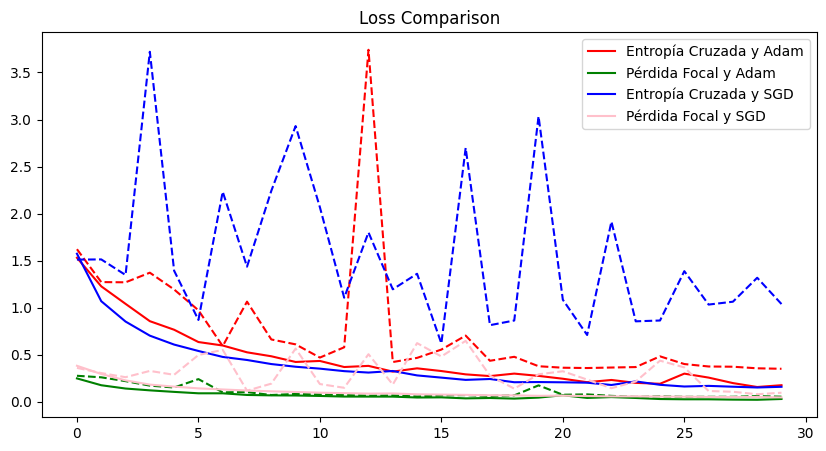

In [36]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_ce_adam.history["loss"], color='r', linestyle='-', label='Entropía Cruzada y Adam')
axis.plot(results_ce_adam.history["val_loss"], color='r', linestyle='--')
axis.plot(results_focal_adam.history["loss"], color='g', linestyle='-', label='Pérdida Focal y Adam')
axis.plot(results_focal_adam.history["val_loss"], color='g', linestyle='--')
axis.plot(results_ce_sgd.history["loss"], color='b', linestyle='-', label='Entropía Cruzada y SGD')
axis.plot(results_ce_sgd.history["val_loss"], color='b', linestyle='--')
axis.plot(results_focal_sgd.history["loss"], color='pink', linestyle='-', label='Pérdida Focal y SGD')
axis.plot(results_focal_sgd.history["val_loss"], color='pink', linestyle='--')
axis.set_title('Loss Comparison')
axis.legend()

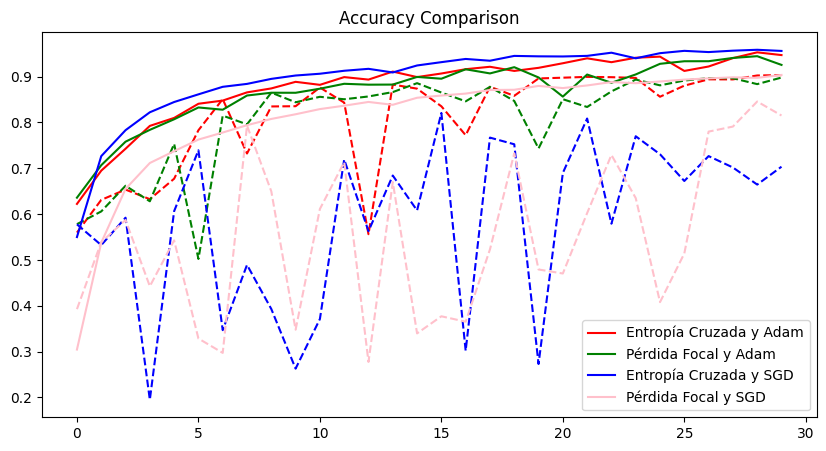

In [37]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_ce_adam.history["accuracy"], color='r', linestyle='-', label='Entropía Cruzada y Adam')
axis.plot(results_ce_adam.history["val_accuracy"], color='r', linestyle='--')
axis.plot(results_focal_adam.history["accuracy_one_hot"], color='g', linestyle='-', label='Pérdida Focal y Adam')
axis.plot(results_focal_adam.history["val_accuracy_one_hot"], color='g', linestyle='--')
axis.plot(results_ce_sgd.history["accuracy"], color='b', linestyle='-', label='Entropía Cruzada y SGD')
axis.plot(results_ce_sgd.history["val_accuracy"], color='b', linestyle='--')
axis.plot(results_focal_sgd.history["accuracy_one_hot"], color='pink', linestyle='-', label='Pérdida Focal y SGD')
axis.plot(results_focal_sgd.history["val_accuracy_one_hot"], color='pink', linestyle='--')
axis.set_title('Accuracy Comparison')
axis.legend()

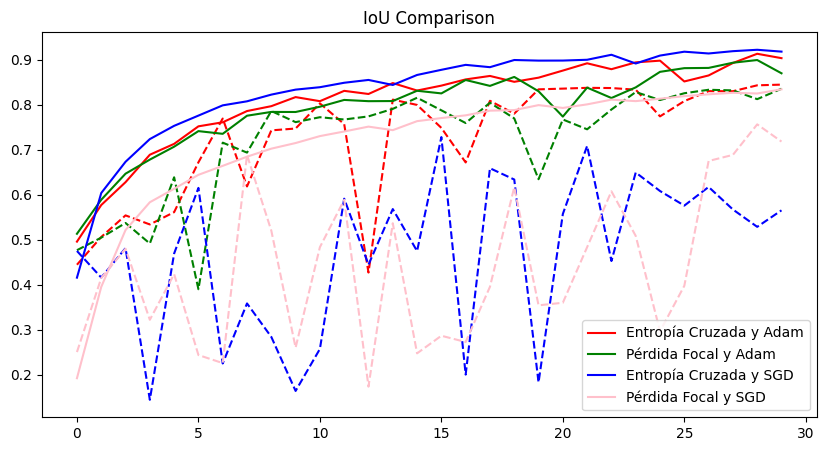

In [38]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_ce_adam.history["iou"], color='r', linestyle='-', label='Entropía Cruzada y Adam')
axis.plot(results_ce_adam.history["val_iou"], color='r', linestyle='--')
axis.plot(results_focal_adam.history["iou_one_hot"], color='g', linestyle='-', label='Pérdida Focal y Adam')
axis.plot(results_focal_adam.history["val_iou_one_hot"], color='g', linestyle='--')
axis.plot(results_ce_sgd.history["iou"], color='b', linestyle='-', label='Entropía Cruzada y SGD')
axis.plot(results_ce_sgd.history["val_iou"], color='b', linestyle='--')
axis.plot(results_focal_sgd.history["iou_one_hot"], color='pink', linestyle='-', label='Pérdida Focal y SGD')
axis.plot(results_focal_sgd.history["val_iou_one_hot"], color='pink', linestyle='--')
axis.set_title('IoU Comparison')
axis.legend()

## Evaluación del modelo

In [39]:
def print_classes_score(score):
    print("\tFondo:\t\t\t{:.2f}".format(score[0] * 100))
    print("\tAcera:\t\t\t{:.2f}".format(score[1] * 100))
    print("\tBaldosas podotáctiles:\t{:.2f}".format(score[2] * 100))
    print("\tBanco:\t\t\t{:.2f}".format(score[3] * 100))
    print("\tCarretera:\t\t{:.2f}".format(score[4] * 100))
    print("\tPared:\t\t\t{:.2f}".format(score[5] * 100))
    print("\tPaso de cebra:\t\t{:.2f}".format(score[6] * 100))
    print("\tVegetación:\t\t{:.2f}".format(score[7] * 100))
    return

### Pérdida focal y Adam

In [62]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_focal_adam.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 18ms/step


In [63]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

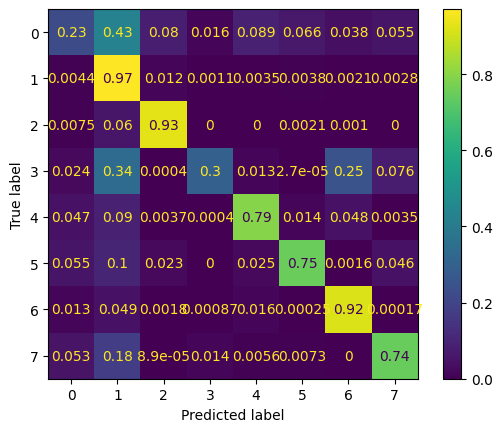

In [64]:
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [65]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 89.32
global accuracy: 89.32
global precision: 89.32
global recall: 89.32
global iou: 80.70
----------------------------------
weighted dice_coef: 88.75
weighted precision: 88.61
weighted recall: 89.32
weighted iou: 81.64
----------------------------------
Dice_coef per class: 
	Fondo:			26.89
	Acera:			94.59
	Baldosas podotáctiles:	86.93
	Banco:			40.18
	Carretera:		82.82
	Pared:			82.20
	Paso de cebra:		92.84
	Vegetación:		74.25
Precision per class: 
	Fondo:			33.10
	Acera:			92.21
	Baldosas podotáctiles:	81.64
	Banco:			61.61
	Carretera:		86.70
	Pared:			91.16
	Paso de cebra:		93.78
	Vegetación:		74.04
Recall per class: 
	Fondo:			22.65
	Acera:			97.09
	Baldosas podotáctiles:	92.96
	Banco:			29.81
	Carretera:		79.27
	Pared:			74.85
	Paso de cebra:		91.92
	Vegetación:		74.46
IoU per class: 
	Fondo:			15.53
	Acera:			89.73
	Baldosas podotáctiles:	76.88
	Banco:			25.14
	Carretera:		70.68
	Pared:			69.78
	Paso de cebra:		86.64
	Vegeta

### Pérdida focal y SGD

In [66]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_focal_sgd.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 18ms/step


In [67]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

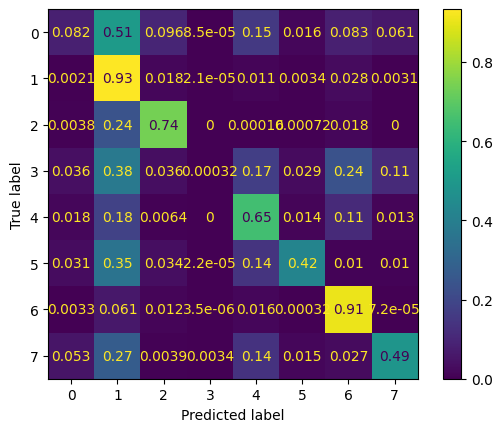

In [68]:
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [69]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 80.77
global accuracy: 80.77
global precision: 80.77
global recall: 80.77
global iou: 67.74
----------------------------------
weighted dice_coef: 78.85
weighted precision: 78.97
weighted recall: 80.77
weighted iou: 68.03
----------------------------------
Dice_coef per class: 
	Fondo:			12.45
	Acera:			89.21
	Baldosas podotáctiles:	71.20
	Banco:			0.06
	Carretera:		63.69
	Pared:			57.06
	Paso de cebra:		84.91
	Vegetación:		57.08
Precision per class: 
	Fondo:			25.51
	Acera:			85.40
	Baldosas podotáctiles:	68.61
	Banco:			2.41
	Carretera:		62.18
	Pared:			88.43
	Paso de cebra:		79.83
	Vegetación:		69.15
Recall per class: 
	Fondo:			8.23
	Acera:			93.38
	Baldosas podotáctiles:	74.00
	Banco:			0.03
	Carretera:		65.28
	Pared:			42.12
	Paso de cebra:		90.68
	Vegetación:		48.60
IoU per class: 
	Fondo:			6.64
	Acera:			80.52
	Baldosas podotáctiles:	55.28
	Banco:			0.03
	Carretera:		46.73
	Pared:			39.92
	Paso de cebra:		73.77
	Vegetación:	

### Entropía cruzada categórica dispersa y Adam

In [70]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_ce_adam.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 20ms/step


In [71]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

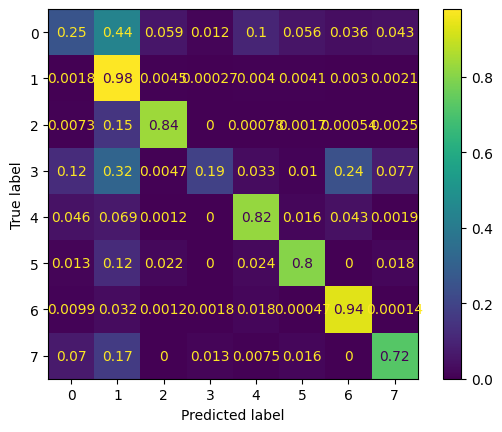

In [72]:
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [73]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 90.14
global accuracy: 90.14
global precision: 90.14
global recall: 90.14
global iou: 82.05
----------------------------------
weighted dice_coef: 89.42
weighted precision: 89.23
weighted recall: 90.14
weighted iou: 82.64
----------------------------------
Dice_coef per class: 
	Fondo:			31.99
	Acera:			94.84
	Baldosas podotáctiles:	85.57
	Banco:			28.87
	Carretera:		84.03
	Pared:			85.27
	Paso de cebra:		93.80
	Vegetación:		76.42
Precision per class: 
	Fondo:			43.12
	Acera:			91.87
	Baldosas podotáctiles:	87.66
	Banco:			59.87
	Carretera:		85.78
	Pared:			91.21
	Paso de cebra:		93.95
	Vegetación:		81.23
Recall per class: 
	Fondo:			25.42
	Acera:			98.02
	Baldosas podotáctiles:	83.58
	Banco:			19.02
	Carretera:		82.35
	Pared:			80.06
	Paso de cebra:		93.64
	Vegetación:		72.14
IoU per class: 
	Fondo:			19.04
	Acera:			90.19
	Baldosas podotáctiles:	74.79
	Banco:			16.87
	Carretera:		72.46
	Pared:			74.32
	Paso de cebra:		88.32
	Vegeta

### Entropía cruzada categóriza dispersa y SGD

In [74]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_ce_sgd.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 21ms/step


In [75]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

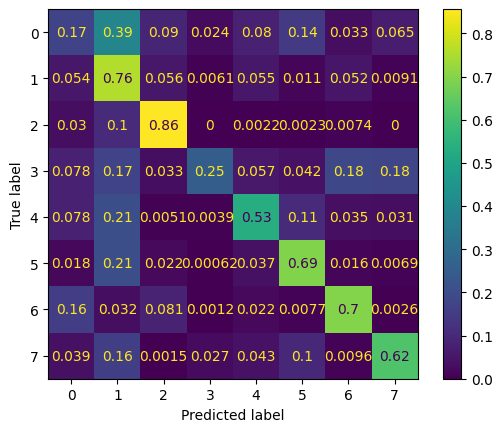

In [76]:
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [77]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 70.40
global accuracy: 70.40
global precision: 70.40
global recall: 70.40
global iou: 54.32
----------------------------------
weighted dice_coef: 72.15
weighted precision: 75.10
weighted recall: 70.40
weighted iou: 58.20
----------------------------------
Dice_coef per class: 
	Fondo:			10.84
	Acera:			81.21
	Baldosas podotáctiles:	62.49
	Banco:			26.98
	Carretera:		51.14
	Pared:			69.74
	Paso de cebra:		70.91
	Vegetación:		61.35
Precision per class: 
	Fondo:			7.90
	Acera:			87.68
	Baldosas podotáctiles:	49.19
	Banco:			29.15
	Carretera:		49.13
	Pared:			70.01
	Paso de cebra:		72.21
	Vegetación:		60.64
Recall per class: 
	Fondo:			17.23
	Acera:			75.63
	Baldosas podotáctiles:	85.63
	Banco:			25.11
	Carretera:		53.32
	Pared:			69.47
	Paso de cebra:		69.65
	Vegetación:		62.08
IoU per class: 
	Fondo:			5.73
	Acera:			68.37
	Baldosas podotáctiles:	45.44
	Banco:			15.59
	Carretera:		34.36
	Pared:			53.54
	Paso de cebra:		54.93
	Vegetaci

## Visualización de predicciones

In [78]:
def VisualizeResults(index):
    img = X_test[index]
    img = img[np.newaxis, ...]
    pred_y = model_ce_adam.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask_color = label_to_color_image(pred_mask).astype(np.uint8)
    truth_mask_color = label_to_color_image(y_test[index,:,:,0]).astype(np.uint8)
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_test[index])
    arr[0].set_title('Imagen preprocesada')
    arr[1].imshow(truth_mask_color)
    arr[1].set_title('Máscara real')
    arr[2].imshow(pred_mask_color)
    arr[2].set_title('Máscara predicha')

1/1 [==============================] - 0s 19ms/step


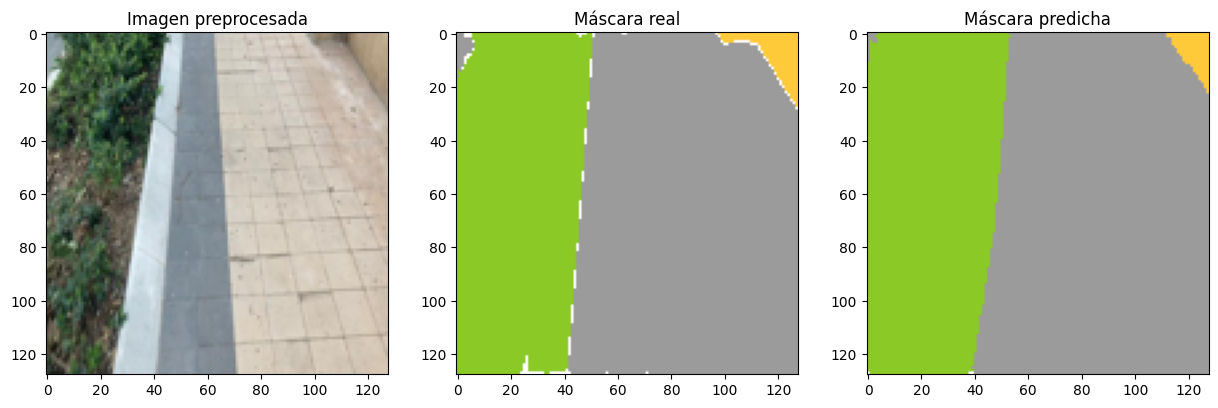

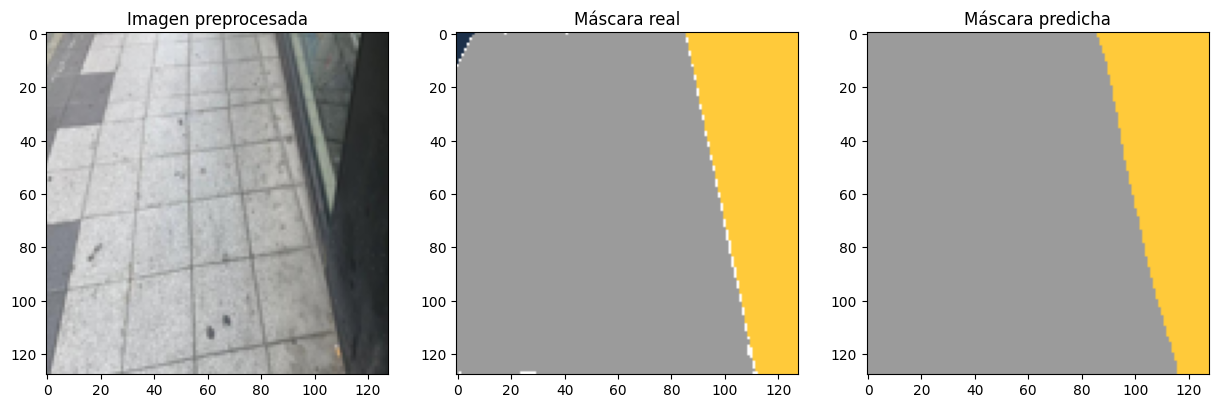

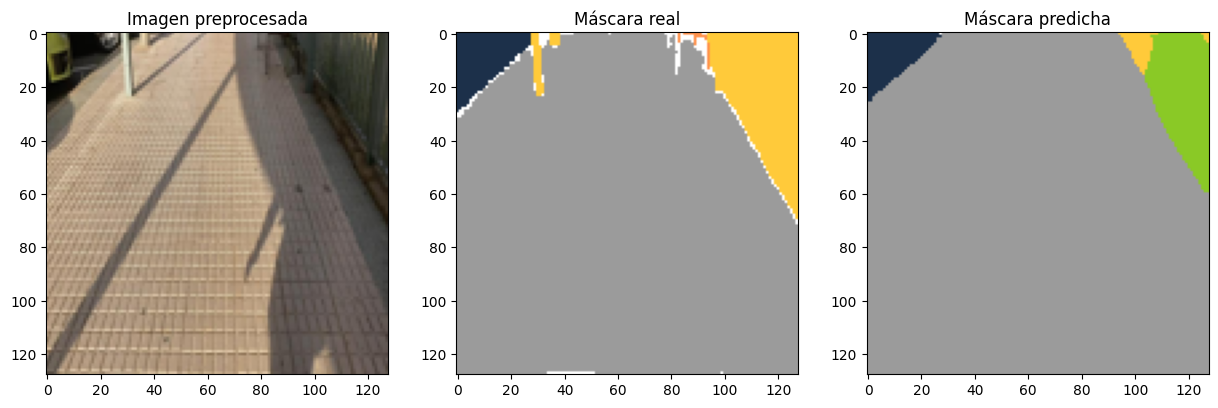

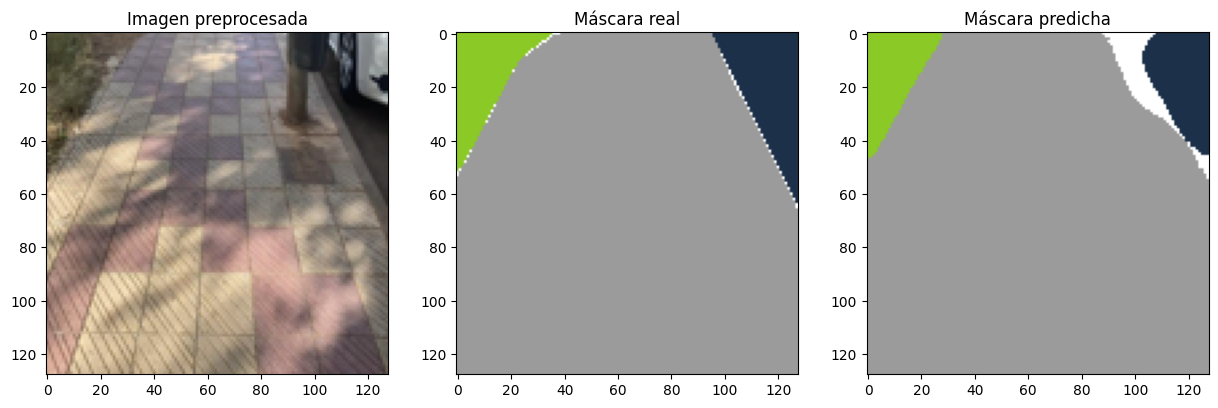

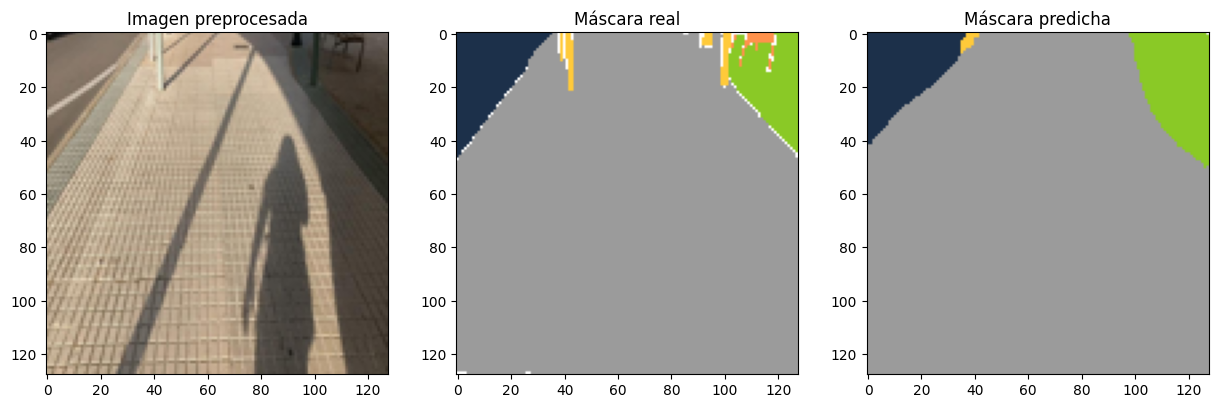

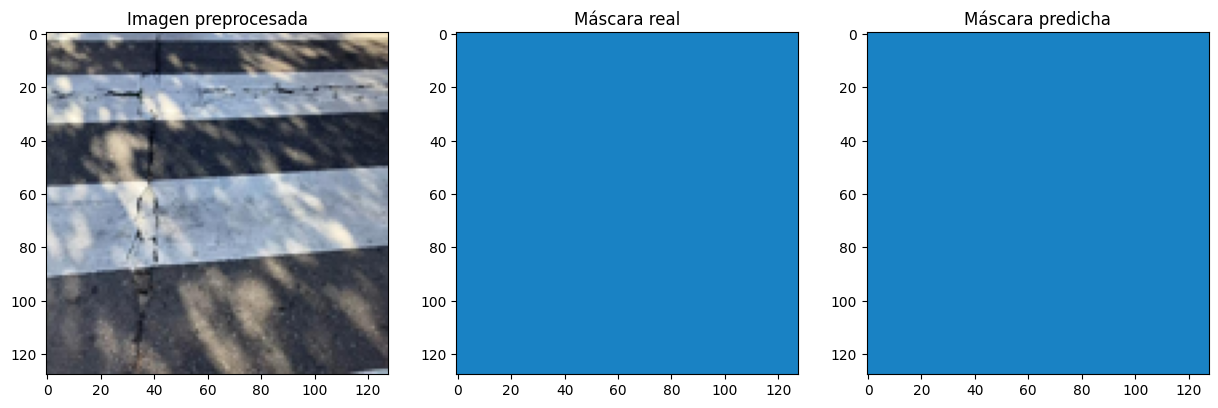

In [79]:
show_images = 6
random_ints = np.random.randint(0, NUM_TEST_IMAGES - 1, size=show_images)
for num in random_ints:
    VisualizeResults(num)

## Descarga del modelo entrenado

In [ ]:
model.save('/content/modelo_SegNet.keras')
files.download("/content/modelo_SegNet.keras")

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>